# Semi-supervised Community Detection using Graph Neural Networks

Almost every computer 101 class starts with a "Hello World" example. Like MNIST for deep learning, in graph domain we have the Zachary's Karate Club problem. The karate club is a social network that includes 34 members and documents pairwise links between members who interact outside the club. The club later divides into two communities led by the instructor (node 0) and the club president (node 33). The network is visualized as follows with the color indicating the community.

<img src='../asset/karat_club.png' align='center' width="400px" height="300px" />

In this tutorial, you will learn:

* Formulate the community detection problem as a semi-supervised node classification task.
* Build a GraphSAGE model, a popular Graph Neural Network architecture proposed by [Hamilton et al.](https://arxiv.org/abs/1706.02216)
* Train the model and understand the result.

In [2]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools

## Community detection as node classification

The study of community structure in graphs has a long history. Many proposed methods are *unsupervised* (or *self-supervised* by recent definition), where the model predicts the community labels only by connectivity. Recently, [Kipf et al.,](https://arxiv.org/abs/1609.02907) proposed to formulate the community detection problem as a semi-supervised node classification task. With the help of only a small portion of labeled nodes, a GNN can accurately predict the community labels of the others.

In this tutorial, we apply Kipf's setting to the Zachery's Karate Club network to predict the community membership, where only the labels of a few nodes are used.

We first load the graph and node labels as is covered in the [last session](./1_load_data.ipynb). Here, we have provided you a function for loading the data.

In [3]:
from tutorial_utils import load_zachery

# ----------- 0. load graph -------------- #
g = load_zachery()
print(g)

Graph(num_nodes=34, num_edges=156,
      ndata_schemes={'club': Scheme(shape=(), dtype=torch.int64), 'club_onehot': Scheme(shape=(2,), dtype=torch.int64)}
      edata_schemes={})


In the original Zachery's Karate Club graph, nodes are feature-less. (The `'Age'` attribute is an artificial one mainly for tutorial purposes). For feature-less graph, a common practice is to use an embedding weight that is updated during training for every node.

We can use PyTorch's `Embedding` module to achieve this.

In [4]:
# ----------- 1. node features -------------- #
node_embed = nn.Embedding(g.number_of_nodes(), 5)  # Every node has an embedding of size 5.
inputs = node_embed.weight                         # Use the embedding weight as the node features.
nn.init.xavier_uniform_(inputs)
print(inputs)

Parameter containing:
tensor([[ 0.2457,  0.3730,  0.3507, -0.2188, -0.1556],
        [ 0.0450, -0.1823, -0.3407,  0.2766,  0.1490],
        [ 0.2128,  0.1139, -0.3702,  0.1000,  0.0193],
        [ 0.0990, -0.2001, -0.1905,  0.2368,  0.1447],
        [-0.3455,  0.1899, -0.2955, -0.0307,  0.2717],
        [-0.1182,  0.1500,  0.3286,  0.0985,  0.3326],
        [-0.3337, -0.2519,  0.2539, -0.2553, -0.3534],
        [-0.2723,  0.0085,  0.1608,  0.1358,  0.2449],
        [-0.0700, -0.1192,  0.0248, -0.0111, -0.3606],
        [ 0.2620,  0.0277,  0.2110, -0.2736, -0.1675],
        [ 0.2939,  0.1399,  0.3022, -0.2436, -0.0282],
        [ 0.3421, -0.2074,  0.3128, -0.0046, -0.3437],
        [-0.0146, -0.3602, -0.2081,  0.2210, -0.1536],
        [-0.2789, -0.2583, -0.2077, -0.2503,  0.1271],
        [-0.2873,  0.0900,  0.3487,  0.2975,  0.3798],
        [-0.0193,  0.2663,  0.3097,  0.2957,  0.0256],
        [-0.2679, -0.3875,  0.1542, -0.1395, -0.3002],
        [-0.3156, -0.1597, -0.1594, -0.2205

The community label is stored in the `'club'` node feature (0 for instructor, 1 for club president). Only nodes 0 and 33 are labeled.

In [5]:
labels = g.ndata['club']
labeled_nodes = [0, 33]
print('Labels', labels[labeled_nodes])

Labels tensor([0, 1])


## Define a GCN model

Our model consists of two layers, each computes new node representations by aggregating neighbor information. The equations are:

$$
 h_i^{(l+1)} = \sigma(b^{(l)} + \sum_{j\in\mathcal{N}(i)}\frac{1}{c_{ij}}h_j^{(l)}W^{(l)})
$$

DGL provides implementation of many popular neighbor aggregation modules. They all can be invoked easily with one line of codes. See the full list of supported [graph convolution modules](https://docs.dgl.ai/api/python/nn.pytorch.html#module-dgl.nn.pytorch.conv).

In [12]:
from dgl.nn import GraphConv

# ----------- 2. create model -------------- #
# build a two-layer GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)
    
    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h
    
# Create the model with given dimensions 
# input layer dimension: 5, node embeddings
# hidden layer dimension: 16
# output layer dimension: 2, the two classes, 0 and 1
net = GCN(5, 16, 2)

In [13]:
# ----------- 3. set up loss and optimizer -------------- #
# in this case, loss will in training loop
optimizer = torch.optim.Adam(itertools.chain(net.parameters(), node_embed.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #
all_logits = []
for e in range(100):
    # forward
    logits = net(g, inputs)
    
    # compute loss
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[labeled_nodes], labels[labeled_nodes])
    
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    all_logits.append(logits.detach())
    
    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))

In epoch 0, loss: 0.7200539112091064
In epoch 5, loss: 0.44082432985305786
In epoch 10, loss: 0.24498018622398376
In epoch 15, loss: 0.12030365318059921
In epoch 20, loss: 0.05141899362206459
In epoch 25, loss: 0.020887991413474083
In epoch 30, loss: 0.00925032515078783
In epoch 35, loss: 0.004809806123375893
In epoch 40, loss: 0.0029411138966679573
In epoch 45, loss: 0.0020474977791309357
In epoch 50, loss: 0.00156751973554492
In epoch 55, loss: 0.0012834329390898347
In epoch 60, loss: 0.0011010486632585526
In epoch 65, loss: 0.0009754864731803536
In epoch 70, loss: 0.0008837289642542601
In epoch 75, loss: 0.0008128051995299757
In epoch 80, loss: 0.0007555740303359926
In epoch 85, loss: 0.0007075114408507943
In epoch 90, loss: 0.000665819738060236
In epoch 95, loss: 0.0006290106102824211


In [14]:
# ----------- 5. check results ------------------------ #
pred = torch.argmax(logits, axis=1)
print('Accuracy', (pred == labels).sum().item() / len(pred))

Accuracy 0.9411764705882353


## Visualize the result

Since the GNN produces a logit vector of size 2 for each array. We can plot to a 2-D plane.

<img src='../asset/gnn_ep0.png' align='center' width="400px" height="300px"/>
<img src='../asset/gnn_ep_anime.gif' align='center' width="400px" height="300px"/>

Run the following code to visualize the result. Require ffmpeg.

In [10]:
# A bit of setup, just ignore this cell
import matplotlib.pyplot as plt

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.rcParams['figure.figsize'] = (4.0, 3.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['animation.html'] = 'html5'

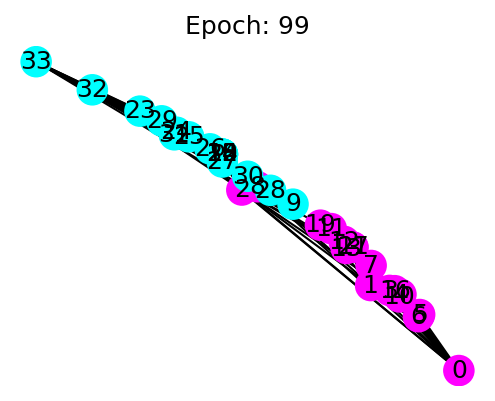

In [11]:
# Visualize the node classification using the logits output. Requires ffmpeg.
import networkx as nx
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
nx_G = g.to_networkx()
def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pred = all_logits[i].numpy()
        pos[v] = pred[v]
        cls = labels[v]
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw(nx_G.to_undirected(), pos, node_color=colors, with_labels=True, node_size=200)

ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
HTML(ani.to_html5_video())

## Exercise

Play with the GNN models by using other [graph convolution modules](https://docs.dgl.ai/api/python/nn.pytorch.html#module-dgl.nn.pytorch.conv).